<a href="https://colab.research.google.com/github/JS555555/CIFAKE_-classifier/blob/main/computer_vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Data preprocessing

In [46]:
train_data_dir = '/content/destination_directory/test/'
valid_data_dir = '/content/destination_directory/train/'

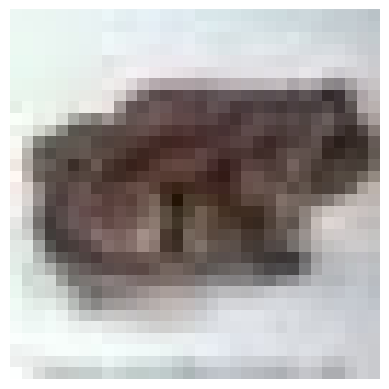

In [47]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

image_files = os.listdir(train_data_dir + 'REAL' )
random_image = random.choice(image_files)
image_path = os.path.join(train_data_dir + 'REAL', random_image)

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [48]:
img_width, img_height = 32, 32
batch_size = 128
epochs = 10

In [49]:
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 100000 images belonging to 2 classes.


### VGG16

In [50]:
base_model_VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_width, img_height, 3)))

for layer in base_model_VGG.layers:
    layer.trainable = False

x = Flatten()(base_model_VGG.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model_VGG = Model(inputs=base_model_VGG.input, outputs=x)

model_VGG.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_VGG.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

In [ ]:
history_VGG = model_VGG.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs,
                    validation_data=valid_generator, validation_steps=valid_generator.samples // batch_size,
                    callbacks=[early_stopping, model_checkpoint])

loss, accuracy = model_VGG.evaluate(valid_generator, steps=valid_generator.samples // batch_size)
print(f'Loss: {loss}, Accuracy: {accuracy}')

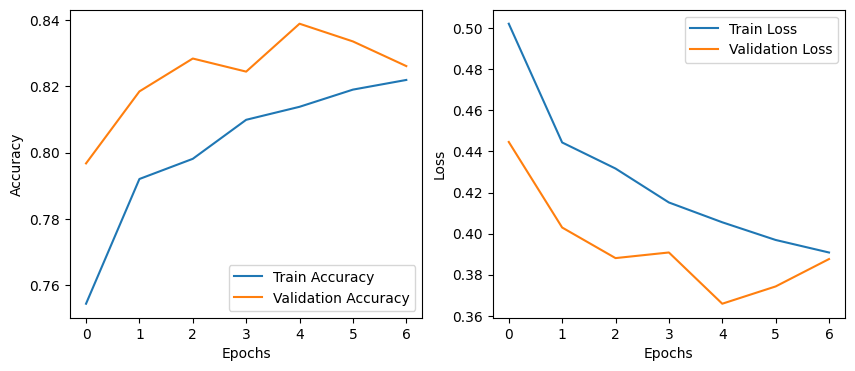

In [61]:
import matplotlib.pyplot as plt

train_accuracy = history_VGG.history['accuracy']
train_loss = history_VGG.history['loss']
val_accuracy = history_VGG.history['val_accuracy']
val_loss = history_VGG.history['val_loss']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### ResNet

In [54]:
base_model_ResNet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_width, img_height, 3)))

for layer in base_model_ResNet.layers:
    layer.trainable = False

x = Flatten()(base_model_ResNet.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model_ResNet = Model(inputs=base_model_ResNet.input, outputs=x)

model_ResNet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_ResNet.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')

In [ ]:
history_ResNet = model_ResNet.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs,
                    validation_data=valid_generator, validation_steps=valid_generator.samples // batch_size,
                    callbacks=[early_stopping, model_checkpoint])

loss, accuracy = model_ResNet.evaluate(valid_generator, steps=valid_generator.samples // batch_size)
print(f'Loss: {loss}, Accuracy: {accuracy}')

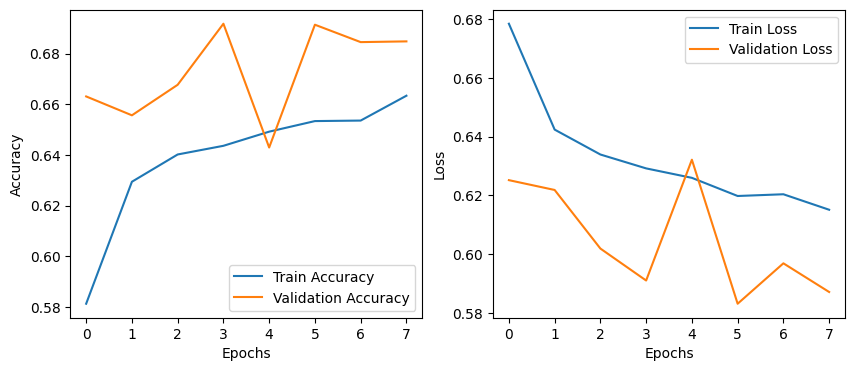

In [60]:
train_accuracy = history_ResNet.history['accuracy']
train_loss = history_ResNet.history['loss']
val_accuracy = history_ResNet.history['val_accuracy']
val_loss = history_ResNet.history['val_loss']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### Choosing the best model and conducting heatmap analysis to understand why the model classified a given image as the class it did.


In [58]:
def compute_gradients(image, model):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image[tf.newaxis, ...])

    gradients = tape.gradient(predictions, image)
    return gradients

1/1 [==============================] - 0s 151ms/step
[[0.57124996]]


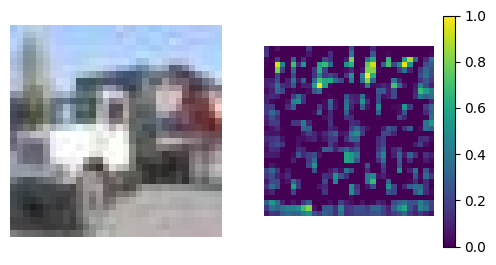

In [59]:
from tensorflow.keras.models import load_model

random_image = random.choice(image_files)
image_path = os.path.join(train_data_dir + 'REAL', random_image)
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)

image = tf.image.convert_image_dtype(image, tf.float32)
image /= 255.0

model = load_model('/content/best_model_VGG.h5')

gradients = compute_gradients(image, model=model)
heatmap = tf.reduce_mean(gradients, axis=-1)

heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='viridis')
plt.colorbar()
plt.axis('off');

print(model.predict(image[tf.newaxis, ...]))